In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.functional import F
import random
from scratch_model import AutoEncoder
from torch.optim import Adam
import pandas as pd
import matplotlib.pyplot as plt
import image_all
# from sklearn.manifold import MDS
# import plotly.express as px
# import plotly.graph_objects as go



<h1>0 = Up | 1 = Down | 2 = Left | 3 = Right

In [2]:
train_sas, test_sas = image_all.get_sas_data()  

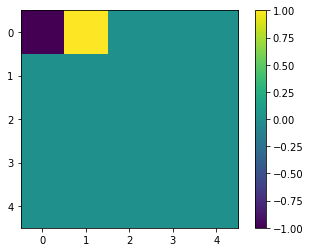

1


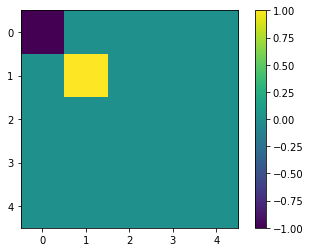

In [3]:
image_all.view_tensor(train_sas[0][0])
print(train_sas[0][1])
image_all.view_tensor(train_sas[0][2])

<h1>Option 1: Action Image to True Image Loss

In [4]:
in_shape = train_sas[0][0].unsqueeze(0).unsqueeze(0).shape
embed_dim = 64 #Seems like optimal one
enc_dropout = 0
dec_dropout = 0.5
model = AutoEncoder(in_shape, embed_dim,dec_drop_out=dec_dropout, enc_drop_out=enc_dropout)
optimizer = Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)


In [5]:
# #Pretrain autoencoder
# train_data, test_data = image_all.get_all_possible_batched(batch_size =5) #Checkerboard of all possible agent start locations (1,5,5 tensors)
# image_all.train_autoencoder(model, optimizer, train_data, test_data, epochs=200)

In [6]:
train_divider = 0.04 * len(train_sas)
test_divider = 0.04 * len(test_sas)
for epoch in range(1000):
    model.train()
    avg_total_loss = 0
    avg_init_decode_loss = 0
    avg_next_decode_loss = 0
    for i in random.sample(range(len(train_sas)), len(train_sas)):
        #Prepare Input Data
        in_s, input_action, in_ns = train_sas[i]
        input_state = in_s.clone() 
        input_next_state = in_ns.clone()
        #Add Noise
        noise = torch.randn_like(input_state) * 0.1
        input_state = input_state + noise   
        noise = torch.randn_like(input_next_state) * 0.1
        input_next_state = input_next_state + noise
        input_state = input_state.unsqueeze(0).unsqueeze(0)
        input_next_state = input_next_state.unsqueeze(0).unsqueeze(0)
        #Get Model Output
        decoded_init_state, decoded_next_state = model(input_state,input_action,input_next_state,option=1)
        #Calculate Loss
        init_decode_loss = F.mse_loss(decoded_init_state.squeeze(0).squeeze(0), train_sas[i][0])
        next_decode_loss= F.mse_loss(decoded_next_state.squeeze(0).squeeze(0), train_sas[i][2])
        total_loss = init_decode_loss + next_decode_loss
        #Add Loss to Average
        avg_init_decode_loss += init_decode_loss.item()
        avg_next_decode_loss += next_decode_loss.item()
        avg_total_loss += total_loss.item()
        #Backpropagate
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        val_avg_total_loss = 0
        val_avg_init_decode_loss = 0
        val_avg_next_decode_loss = 0    
        for i in random.sample(range(len(test_sas)), len(test_sas)):
            model.eval()
            with torch.no_grad():
                input_state, input_action, input_next_state = test_sas[i]
                input_state = input_state.unsqueeze(0).unsqueeze(0)
                input_next_state = input_next_state.unsqueeze(0).unsqueeze(0)
                decoded_init_state, decoded_next_state = model(input_state,input_action,input_next_state,option=1)
                init_decode_loss = F.mse_loss(decoded_init_state.squeeze(0).squeeze(0), test_sas[i][0])
                next_decode_loss= F.mse_loss(decoded_next_state.squeeze(0).squeeze(0), test_sas[i][2])
                total_loss = init_decode_loss + next_decode_loss
                val_avg_init_decode_loss += init_decode_loss.item()
                val_avg_next_decode_loss += next_decode_loss.item()
                val_avg_total_loss += total_loss.item()
        print(f"{epoch}\nTotal Val Loss: {val_avg_total_loss/test_divider} Decode Val Init Loss: {val_avg_init_decode_loss/test_divider} Decode Val Next Loss: {val_avg_next_decode_loss/test_divider}")
    print(f"Total Loss: {avg_total_loss/train_divider} Decode Init Loss: {avg_init_decode_loss/train_divider} Decode Next Loss: {avg_next_decode_loss/train_divider}")

0
Total Val Loss: 3.911555262646921 Decode Val Init Loss: 1.8896402797216305 Decode Val Next Loss: 2.0219149889991335
Total Loss: 4.309679742529989 Decode Init Loss: 2.1222756212577223 Decode Next Loss: 2.18740412495099
Total Loss: 3.5608241241425276 Decode Init Loss: 1.5053978513693438 Decode Next Loss: 2.0554262690711766
Total Loss: 3.1770820749923585 Decode Init Loss: 1.1973318997770548 Decode Next Loss: 1.9797501746565103
Total Loss: 2.9128370394930245 Decode Init Loss: 0.9764206825988367 Decode Next Loss: 1.936416356265545
Total Loss: 2.7177074764855207 Decode Init Loss: 0.8402604187023825 Decode Next Loss: 1.8774470577016473
Total Loss: 2.601908807363361 Decode Init Loss: 0.7763163943542167 Decode Next Loss: 1.8255924125202
Total Loss: 2.4679217850789428 Decode Init Loss: 0.6968385839718394 Decode Next Loss: 1.7710832023527474
Total Loss: 2.3953231861814857 Decode Init Loss: 0.6753439055988565 Decode Next Loss: 1.7199792763218285
Total Loss: 2.3057829345576466 Decode Init Loss: 0

In [7]:
#0.78, 0.31, 0.46 | 2.8, 1.38, 1.44 + transiton
#find good example of agent in the middle. Plug in each action and view decoded tensor. Also check with valid data
train_sas[100] # good example 
test_init_state = train_sas[100][0].unsqueeze(0).unsqueeze(0)
test_next_state = train_sas[100][2].unsqueeze(0).unsqueeze(0)

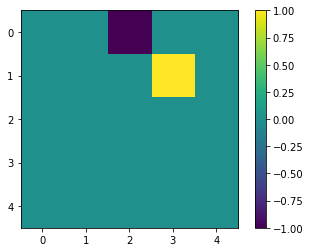

In [8]:
image_all.view_tensor(train_sas[100][0])

In [9]:
action_name_func = lambda x: "Up" if x == 0 else "Down" if x == 1 else "Left" if x == 2 else "Right" if x == 3 else "No Action"

Decoded Tensor


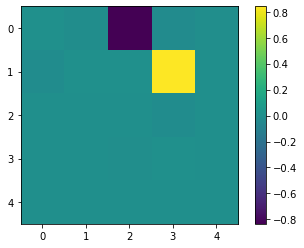

Action: Up


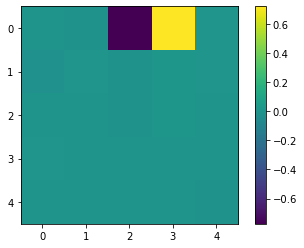

Action: Down


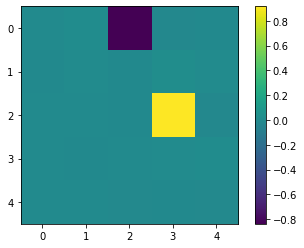

Action: Left


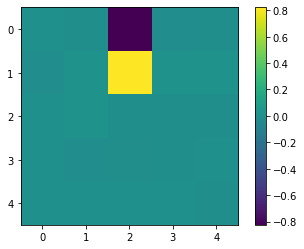

Action: Right


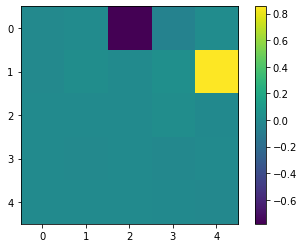

In [10]:
model.eval()
with torch.no_grad():
    decoded_init_state_0, decoded_next_state_0 = model(test_init_state,0,test_next_state,option=1)
    decoded_init_state_1, decoded_next_state_1 = model(test_init_state,1,test_next_state,option=1)
    decoded_init_state_2, decoded_next_state_2 = model(test_init_state,2,test_next_state,option=1)
    decoded_init_state_3, decoded_next_state_3 = model(test_init_state,3,test_next_state,option=1)
#Decoded Tensor
print('Decoded Tensor')
image_all.view_tensor(decoded_init_state_0.squeeze(0).squeeze(0))
for decoded_state, a in zip([decoded_next_state_0,decoded_next_state_1,decoded_next_state_2,decoded_next_state_3],['Up','Down','Left','Right']):
    print('Action:',a)
    image_all.view_tensor(decoded_state.squeeze(0).squeeze(0))


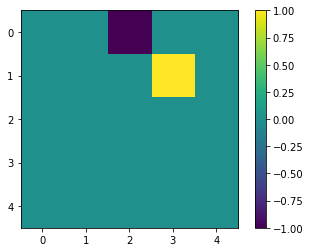

Down


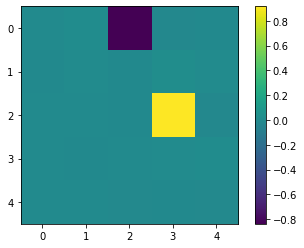

Left


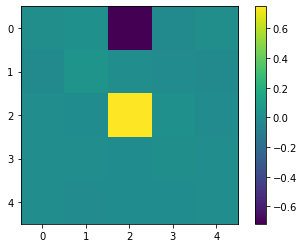

Left


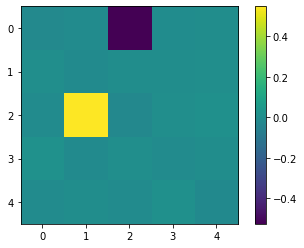

Down


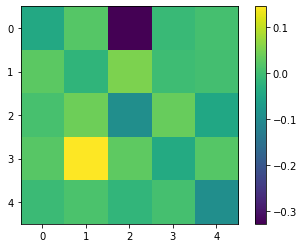

Left


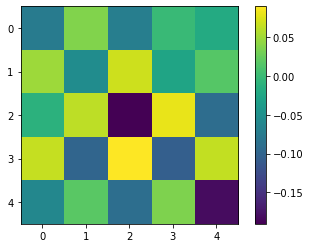

Left


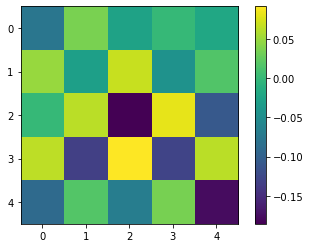

No Action


In [11]:
model.eval()
test_state = train_sas[100][0].unsqueeze(0).unsqueeze(0)
while True:
    image_all.view_tensor(test_state.squeeze(0).squeeze(0))
    action = int(input('Enter Action: '))
    print(action_name_func(action))
    if action > 4:
        break
    _, next_state = model(test_state,action,test_state,option=1)
    test_state = next_state.detach()